
# Business Objectives:


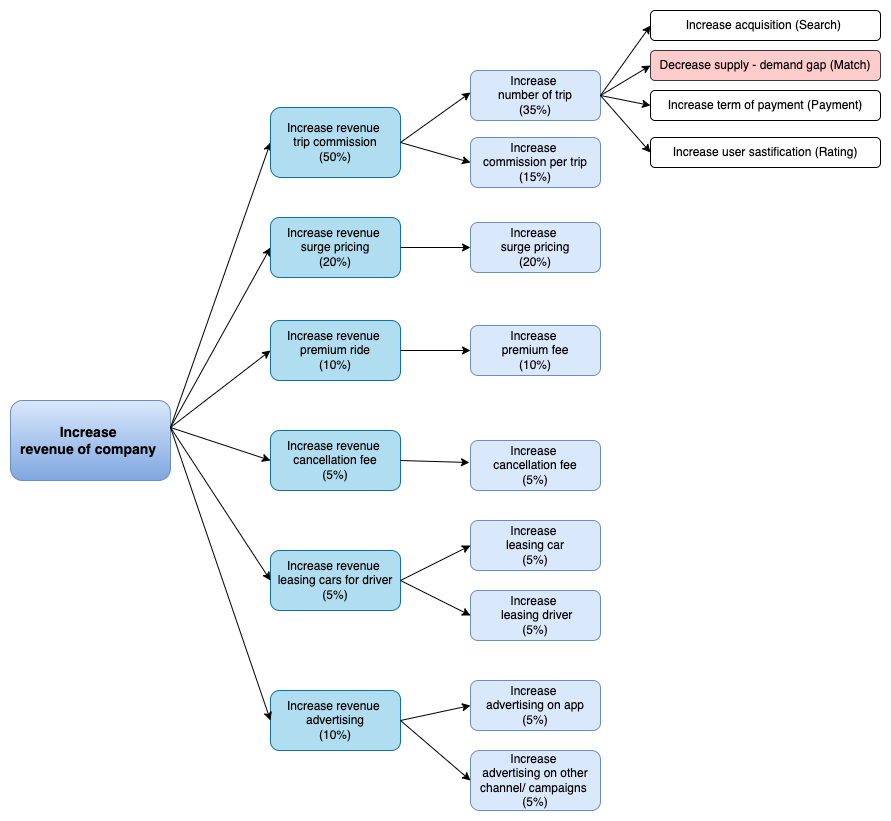

The aim of analysis is to identify the gap between supply and demand of Uber, possible hypotheses of the problem(s) and recommend ways to improve the situation. From that, we can increase the number of trip ->increase revenue from commission trip, thereby increase the revenue of company

# Plan of Analytics

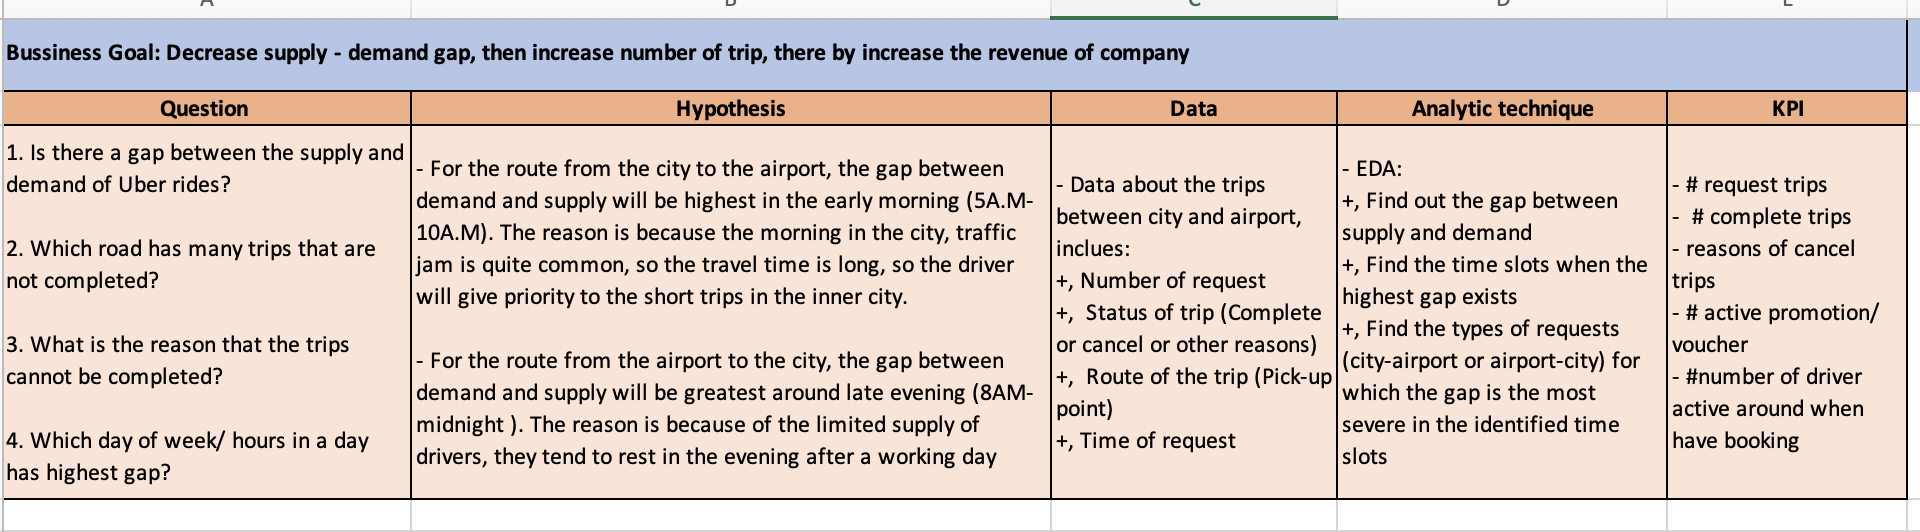

Note: Due to limit of data, for this case study, only the trips to and from the airport are being considered.

# Hypothesis:

1.  For the route **from the city to the airport**, **the gap between demand and supply will be highest in the early morning (5A.M-10A.M).** The reason is because the morning in the city, traffic jam is quite common, so the travel time is long, so the driver will give priority to the short trips in the inner city. 

2. For the route **from the airport to the city, the gap between demand and supply will be highest around late evening (8AM-midnight )**. The reason is because of the limited supply of drivers, they tend to rest in the evening after a working day

# Gather Data

## Data preparation

### import library

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt

### read and check data

In [3]:
df_raw = pd.read_csv('/content/Uber Request Data.csv')
df_raw.head(10)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47
5,3879,Airport,1.0,Trip Completed,13-07-2016 21:57:28,13-07-2016 22:28:59
6,4270,Airport,1.0,Trip Completed,14-07-2016 06:15:32,14-07-2016 07:13:15
7,5510,Airport,1.0,Trip Completed,15-07-2016 05:11:52,15-07-2016 06:07:52
8,6248,City,1.0,Trip Completed,15-07-2016 17:57:27,15-07-2016 18:50:51
9,267,City,2.0,Trip Completed,11/7/2016 6:46,11/7/2016 7:25


In [4]:
# check info of data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


In [5]:
#convert request and drop timestamp to datetime format
df_raw['Request timestamp']=pd.to_datetime(df_raw['Request timestamp'])
df_raw['Drop timestamp']=pd.to_datetime(df_raw['Drop timestamp'])

In [6]:
#replace blanks in column name 
df_raw.columns = [col.replace(' ', '_') for col in df_raw.columns]

In [7]:
df_raw.head()

,Request_id,Pickup_point,Driver_id,Status,Request_timestamp,Drop_timestamp
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


In [8]:
## Check granularity
df_raw['Request_id'].duplicated().sum()

0

### missing data

In [9]:
#Check missing data
df_raw.isnull().sum()

Request_id              0
Pickup_point            0
Driver_id            2650
Status                  0
Request_timestamp       0
Drop_timestamp       3914
dtype: int64

In [10]:
status_count=df_raw[["Request_id","Status"]].groupby("Status").count()
status_count

,Request_id
Status,
Cancelled,1264
No Cars Available,2650
Trip Completed,2831


* "Driver id" column has 2650 missing as shown above but this is equal to the "No cars Available" trip status, hence there are no missing values 
* "Drop Timestamp" columns has 3914 missing values which is the sum of "No cars Available" 2650 and 1264 for "Cancelled" -> We can see that there is no missing data as such the dataset. 

### check duplicate data

In [11]:
# generate count statistics of duplicate entries
if len(df_raw[df_raw.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df_raw[df_raw.duplicated()]))
    print(df_raw[df_raw.duplicated(keep=False)].sort_values(by=list(df_raw.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


There are no duplicated value in dataset 

### drop columns

In [12]:
#drop unnecessary columns
df=df_raw.drop(['Driver_id','Drop_timestamp'], axis=1)
df.head()

,Request_id,Pickup_point,Status,Request_timestamp
0,619,Airport,Trip Completed,2016-11-07 11:51:00
1,867,Airport,Trip Completed,2016-11-07 17:57:00
2,1807,City,Trip Completed,2016-12-07 09:17:00
3,2532,Airport,Trip Completed,2016-12-07 21:08:00
4,3112,City,Trip Completed,2016-07-13 08:33:16


### add more columns

In [13]:
#extract day and hour from the request time
df['Request Date'] = df["Request_timestamp"].dt.date
df['Request Time'] = df["Request_timestamp"].dt.time
df['Request Weekday'] = df['Request_timestamp'].apply(lambda x: dt.datetime.strftime(x, '%A'))
df['Request Hour'] = df['Request_timestamp'].apply(lambda x: x.hour)
df.head()

,Request_id,Pickup_point,Status,Request_timestamp,Request Date,Request Time,Request Weekday,Request Hour
0,619,Airport,Trip Completed,2016-11-07 11:51:00,2016-11-07,11:51:00,Monday,11
1,867,Airport,Trip Completed,2016-11-07 17:57:00,2016-11-07,17:57:00,Monday,17
2,1807,City,Trip Completed,2016-12-07 09:17:00,2016-12-07,09:17:00,Wednesday,9
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,2016-12-07,21:08:00,Wednesday,21
4,3112,City,Trip Completed,2016-07-13 08:33:16,2016-07-13,08:33:16,Wednesday,8


In [14]:
#dividing the trips into 6 sessions based on dt.hour from Request Timestamp

Session_labels=['Late Night','Early Morning','Late Morning','Afternoon','Evening','Night']
df=df.assign(Session=pd.cut(df.Request_timestamp.dt.hour,[-1,4,8,12,16,20,24],labels=Session_labels))
df.head()

,Request_id,Pickup_point,Status,Request_timestamp,Request Date,Request Time,Request Weekday,Request Hour,Session
0,619,Airport,Trip Completed,2016-11-07 11:51:00,2016-11-07,11:51:00,Monday,11,Late Morning
1,867,Airport,Trip Completed,2016-11-07 17:57:00,2016-11-07,17:57:00,Monday,17,Evening
2,1807,City,Trip Completed,2016-12-07 09:17:00,2016-12-07,09:17:00,Wednesday,9,Late Morning
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,2016-12-07,21:08:00,Wednesday,21,Night
4,3112,City,Trip Completed,2016-07-13 08:33:16,2016-07-13,08:33:16,Wednesday,8,Early Morning


Devide trips into 6 session details:
* Late Night: Midnight to 4AM
* Early Morning: 4AM-8AM
* Late Morning: 8AM-Noon
* Afternoon: Noon-4PM
* Evening: 4PM-8PM
* Night: 8PM-Midnight

## EDA

<Figure size 1080x720 with 0 Axes>

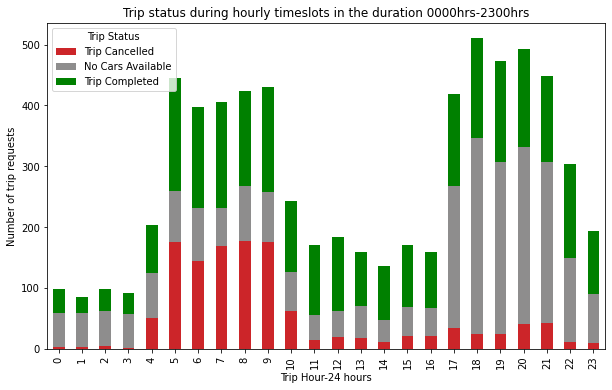

In [15]:
#distribution trips per hour
timeslots=df[["Request_id","Status","Request Hour"]].groupby(["Request Hour","Status"]).count()
plt.figure(figsize=(15,10))
colors = ["#CC2529", "#8E8D8D","#008000"]
timeslots.unstack().plot(kind='bar', stacked=True, figsize=[10,6], legend=True, color=colors)
plt.xlabel("Trip Hour-24 hours")
plt.ylabel("Number of trip requests")
plt.title("Trip status during hourly timeslots in the duration 0000hrs-2300hrs")
plt.legend(title='Trip Status', loc='upper left', labels=['Trip Cancelled', 'No Cars Available', 'Trip Completed'])
plt.show()

Uber has highest demand from 5p.m - 10p.m, after that is from 5a.m - 10a.m. But the completed trip is only ~ 30% total request 

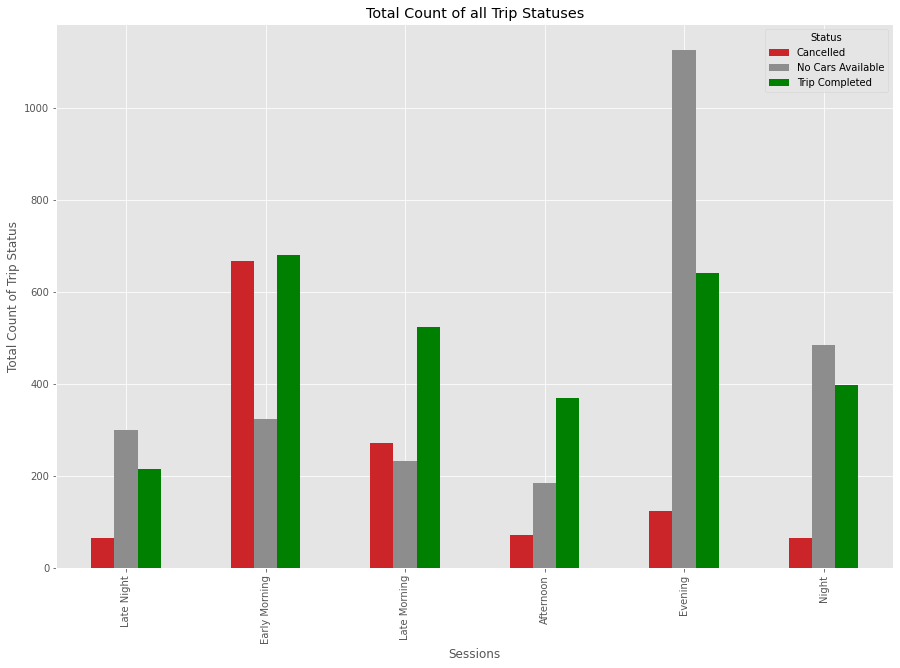

In [16]:
# plotting share/frequency of all "Trip Status" over the day to identify problem areas
plt.style.use('ggplot')
colors = ["#CC2529", "#8E8D8D","#008000"]
df.groupby(['Session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Total Count of all Trip Statuses')
plt.xlabel('Sessions')
plt.ylabel('Total Count of Trip Status')
plt.show()

Observations:
1. Maximum number of "No Cars Available" status trips can be seen in Evening Session (Time Slot: 5PM to 10PM), followed by Night session (8PM to Midnight).
2. Maximum number of "Cancelled" status trips can be seen in Early Morning Session (Time Slot: 4AM to 8AM), followed by Late Morning session (8AM to Noon).


### Status

In [17]:
statuscount=df[["Request_id","Status"]].groupby("Status").count()
statuscount

,Request_id
Status,
Cancelled,1264
No Cars Available,2650
Trip Completed,2831


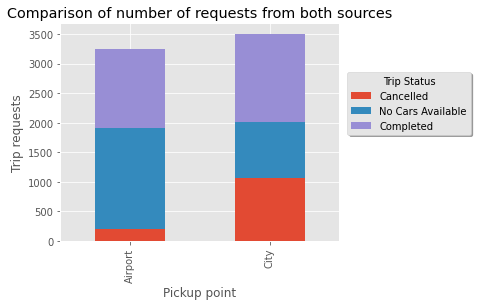

In [18]:
reqtype=df[["Request_id","Status","Pickup_point"]].groupby(["Pickup_point","Status"]).count()

reqtype.unstack().plot(kind='bar', stacked=True, figsize=[5,4])
plt.xlabel("Pickup point")
plt.ylabel("Trip requests")
plt.title("Comparison of number of requests from both sources")
plt.legend(title='Trip Status',loc='upper center', bbox_to_anchor=(1.25, 0.8), shadow=True, ncol=1, labels=['Cancelled', 'No Cars Available', 'Completed'])

There is a very big supply demand gap **Only 42 percent of the total trip requests are being completed**. There are a total of 1**9 percent trips that are being cancelled by the driver** There are **39 percent trip requests which are being turned down due to unavailabiltity of cars **Hence a bigger problem is car unavailability and need to be tackled depending on the where the request is coming from Airport or city

In [19]:
# Filtering out only "Cancelled"  trips
df_tripscancelled=df[df["Status"].str.contains('Cancelled')==True]
df_tripscancelled=df_tripscancelled.reset_index(drop=True)
df_tripscancelled.head()

,Request_id,Pickup_point,Status,Request_timestamp,Request Date,Request Time,Request Weekday,Request Hour,Session
0,2905,City,Cancelled,2016-07-13 06:08:41,2016-07-13,06:08:41,Wednesday,6,Early Morning
1,4805,City,Cancelled,2016-07-14 17:07:58,2016-07-14,17:07:58,Thursday,17,Evening
2,5202,Airport,Cancelled,2016-07-14 20:51:37,2016-07-14,20:51:37,Thursday,20,Evening
3,5927,City,Cancelled,2016-07-15 10:12:40,2016-07-15,10:12:40,Friday,10,Late Morning
4,2347,Airport,Cancelled,2016-12-07 19:14:00,2016-12-07,19:14:00,Wednesday,19,Evening


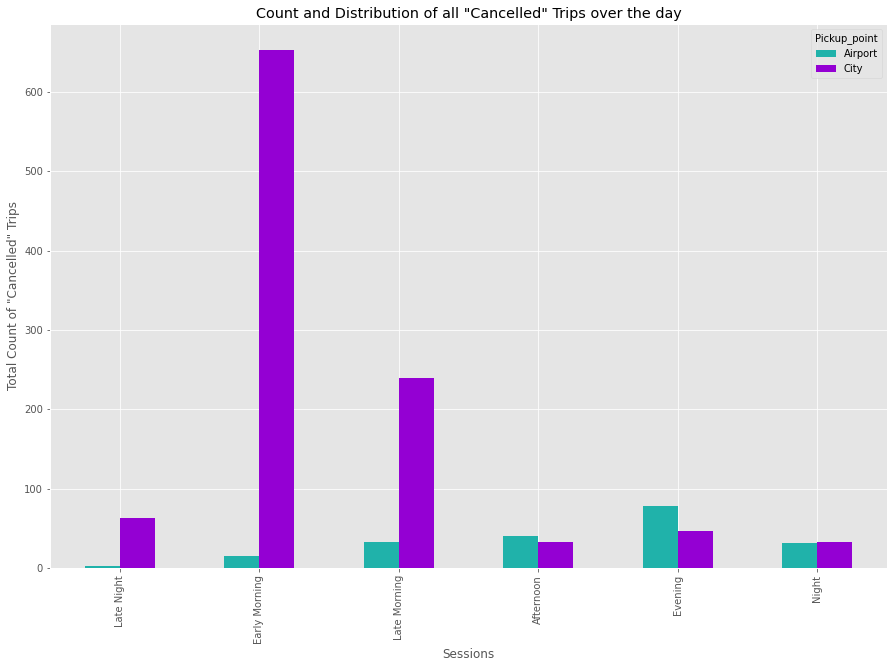

In [20]:
# plotting share/frequency of all Cancelled trips over the day to identify problem areas
plt.style.use('ggplot')
colors = ["#20B2AA", "#9400D3"]
df_tripscancelled.groupby(['Session','Pickup_point']).Pickup_point.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Count and Distribution of all "Cancelled" Trips over the day')
plt.xlabel('Sessions')
plt.ylabel('Total Count of "Cancelled" Trips')
plt.show()

Obervations: 
> Maximum Cancellations happen in "Early Morning" (4AM-8AM) session where the pick up is "City", followed by Late Morning session (8AM-Noon)

=> Inference:
**Most number of cancellations** happen in the **Morning hours (4AM-8AM)** in the **City to Airport** route

In [21]:
# Filtering out only "No Cars Available"  trips
df_nocar=df[df["Status"].str.contains('No Car')==True]
df_nocar=df_nocar.reset_index(drop=True)
df_nocar.head()

,Request_id,Pickup_point,Status,Request_timestamp,Request Date,Request Time,Request Weekday,Request Hour,Session
0,1362,City,No Cars Available,2016-11-07 00:02:00,2016-11-07,00:02:00,Monday,0,Late Night
1,1364,City,No Cars Available,2016-11-07 00:06:00,2016-11-07,00:06:00,Monday,0,Late Night
2,1366,City,No Cars Available,2016-11-07 00:09:00,2016-11-07,00:09:00,Monday,0,Late Night
3,2,Airport,No Cars Available,2016-11-07 00:23:00,2016-11-07,00:23:00,Monday,0,Late Night
4,7,Airport,No Cars Available,2016-11-07 00:30:00,2016-11-07,00:30:00,Monday,0,Late Night


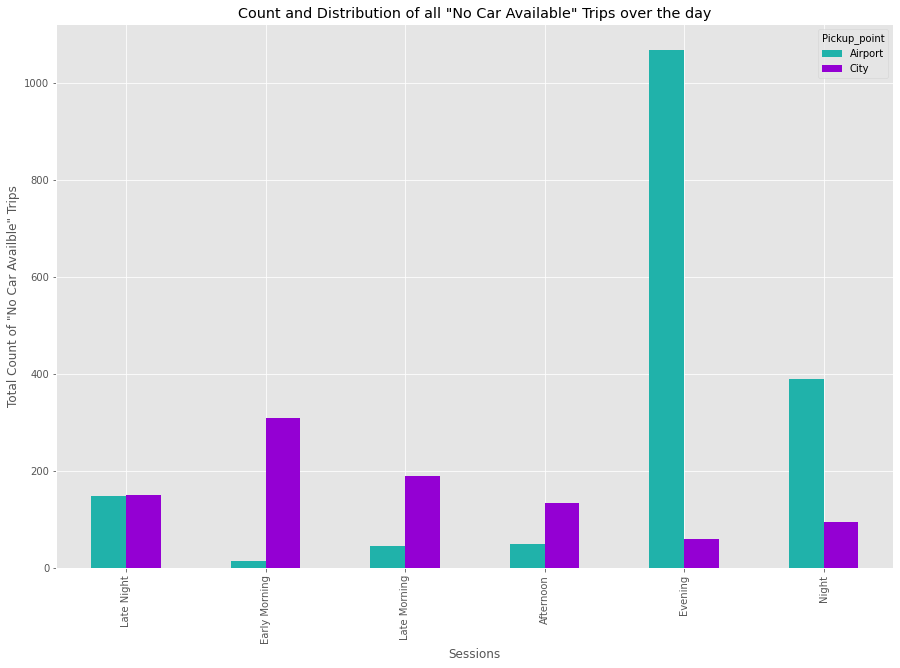

In [22]:
plt.style.use('ggplot')
colors = ["#20B2AA", "#9400D3"]
df_nocar.groupby(['Session','Pickup_point']).Pickup_point.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Count and Distribution of all "No Car Available" Trips over the day')
plt.xlabel('Sessions')
plt.ylabel('Total Count of "No Car Availble" Trips')
plt.show()

Observation
> Maximum "No Cars Available" trips happen in "Evening" (4PM-8PM) session where the pick up is "Airport", followed by Night session (8PM-Midnight)

=> Inference: **Most number of No Cars Available** happen in the **Evening Hours (4PM-8PM)** in the **Airport to City** route



### Pick-up points

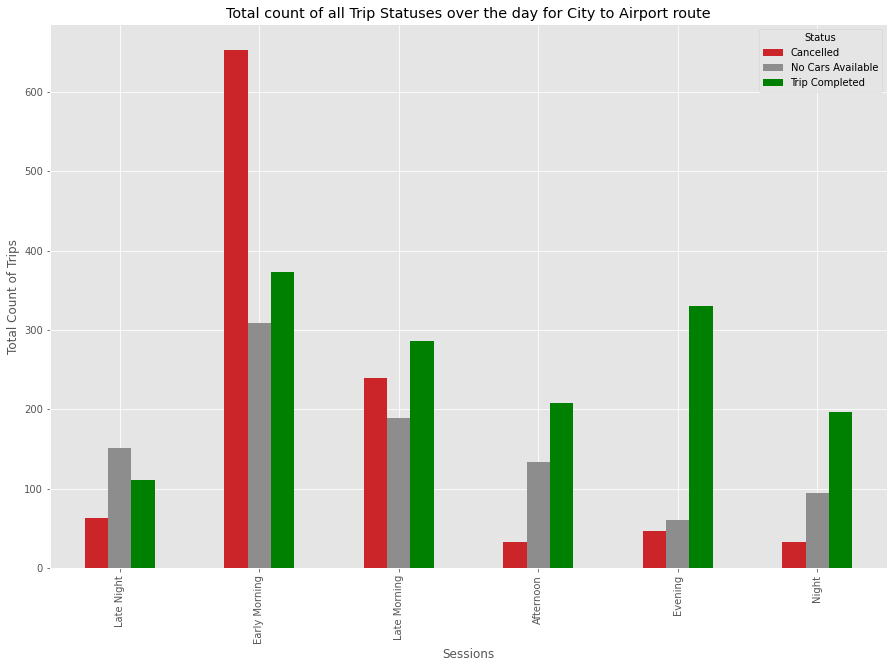

In [23]:
# Filtering out trips in the City to Airport route which has Pick-up Point = City
df_citytoairport=df[df["Pickup_point"].str.contains('City')==True]
plt.style.use('ggplot')
colors = ["#CC2529", "#8E8D8D","#008000"]
df_citytoairport.groupby(['Session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Total count of all Trip Statuses over the day for City to Airport route')
plt.xlabel('Sessions')
plt.ylabel('Total Count of Trips')
plt.show()

Observations: 
> We see that maximum trips are cancelled from City to airport in the Early Morning session followed by Late Morning Session

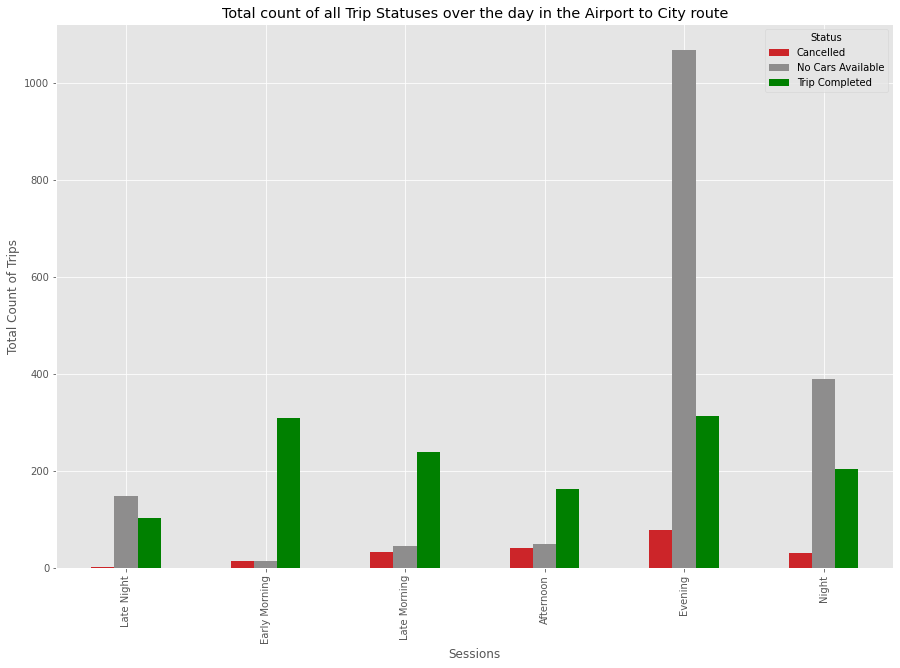

In [24]:
# Filtering out trips in the Airport to route which has Pick-up Point - Airport
df_airporttocity=df[df["Pickup_point"].str.contains('Airport')==True]
plt.style.use('ggplot')
colors = ["#CC2529", "#8E8D8D","#008000"]
df_airporttocity.groupby(['Session','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(15,10), color=colors)
plt.title('Total count of all Trip Statuses over the day in the Airport to City route')
plt.xlabel('Sessions')
plt.ylabel('Total Count of Trips')
plt.show()

Observation: 
> We see that maximum number of "No Cars Available" from Airport to city in the Evening session followed by Night Session

### Supply - Demand gap

Lets try to understand the **Supply and Demand curve** by considering all **Trips Completed as Supply** and **Cancelled and No Cars Available as Demand**

In [26]:
df['Supply_Demand'] = ['Supply' if x == 'Trip Completed' else 'Demand' for x in df['Status']]
df.head()

,Request_id,Pickup_point,Status,Request_timestamp,Request Date,Request Time,Request Weekday,Request Hour,Session,Supply_Demand
0,619,Airport,Trip Completed,2016-11-07 11:51:00,2016-11-07,11:51:00,Monday,11,Late Morning,Supply
1,867,Airport,Trip Completed,2016-11-07 17:57:00,2016-11-07,17:57:00,Monday,17,Evening,Supply
2,1807,City,Trip Completed,2016-12-07 09:17:00,2016-12-07,09:17:00,Wednesday,9,Late Morning,Supply
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,2016-12-07,21:08:00,Wednesday,21,Night,Supply
4,3112,City,Trip Completed,2016-07-13 08:33:16,2016-07-13,08:33:16,Wednesday,8,Early Morning,Supply


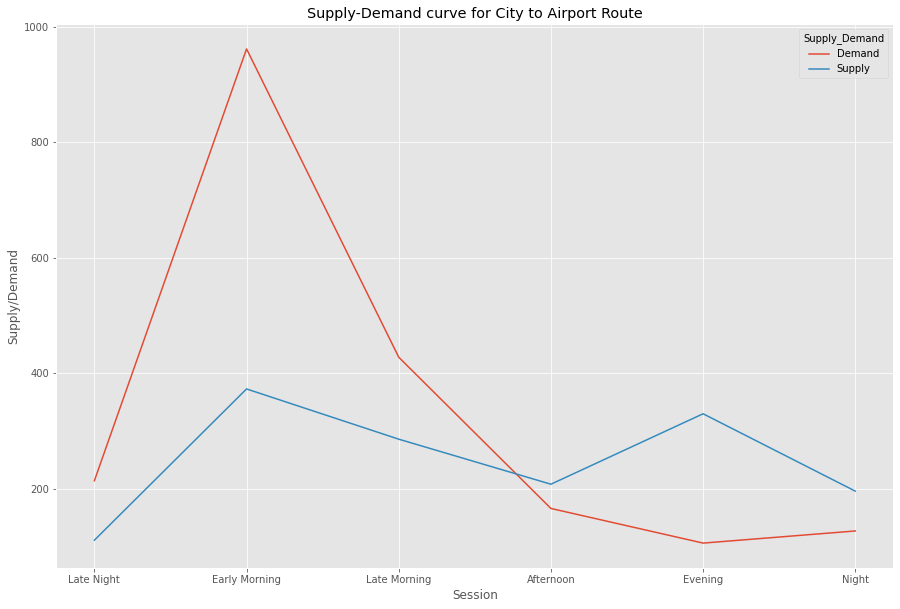

In [27]:
#Plotting Supply and Demand on the City to Airport Route
df_citytoairport_supplydemand=df[df["Pickup_point"].str.contains('City')==True]
plt.style.use('ggplot')
df_citytoairport_supplydemand.groupby(['Session','Supply_Demand']).Supply_Demand.count().unstack().plot.line(legend=True, figsize=(15,10))
plt.title('Supply-Demand curve for City to Airport Route')
plt.xlabel('Session')
plt.ylabel('Supply/Demand')
plt.show()


We observe that **the Demand is very high in the morning from City to Airport route but the supply is very low**

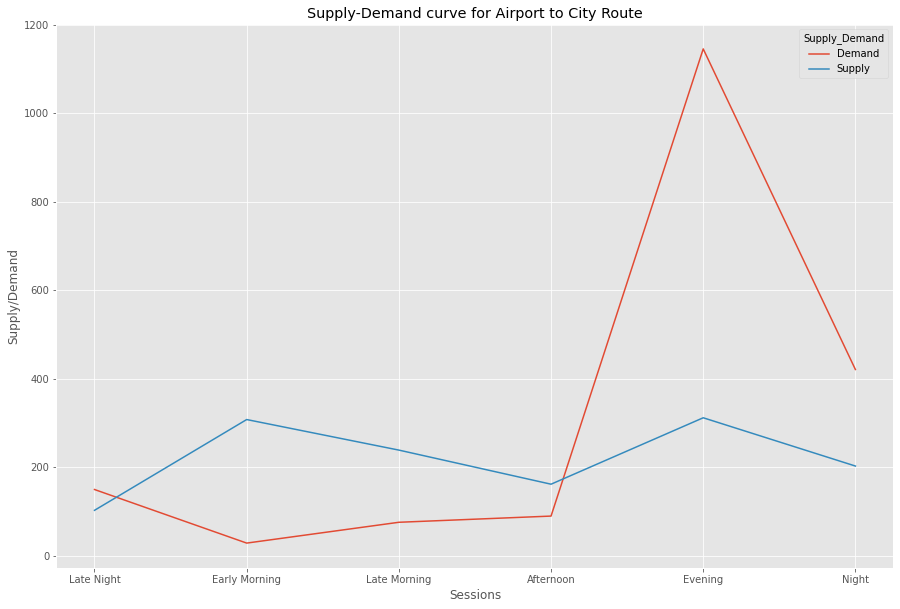

In [28]:
#Plotting Supply and Demand on the Airport to City route
df_airporttocity_supplydemand=df[df["Pickup_point"].str.contains('Airport')==True]
plt.style.use('ggplot')
df_airporttocity_supplydemand.groupby(['Session','Supply_Demand']).Supply_Demand.count().unstack().plot.line(legend=True, figsize=(15,10))
plt.title('Supply-Demand curve for Airport to City Route')
plt.xlabel('Sessions')
plt.ylabel('Supply/Demand')
plt.show()

We observe that **the Demand is very high in the evening in the Airport to City route but the supply is very low**

# Validate hypothesis

Correlating these three plots, a possible hypothesis could be:
* **For the route from the city to the airport,** **the gap between demand and supply will be highest in the early morning and late morning(4A.M-12A.M)**. The reason is not only **because of traffic jam** in the city morning so the driver will give priority to the short trips within city but also **the demand during morning and afternoon hours from the Airport to City is quite low**, which means that **a driver who completed a City to Airport route in the morning hours may have to wait a really long time to get a ride back to the City, or he may have to come back without a passenger**. Both situations are not idle for drivers, which might be the reason for highest number of **"Cancelled" trips**  in the City to Airport trip in the morning hours

>
* **For the route from the airport to the city,** **the gap between demand and supply will be highest around late evening (5PM-midnight )**. The reason is because of the **limited supply of drivers**, not only they tend to rest in the evening after a working day but there are too many flight coming in to the airport and hence there is a high demand for cabs and not enough supply. which is why most number of **"No Cars Available"** were observed in Evening in the Airport to City route.

# Recommendation and KPI to monitor result

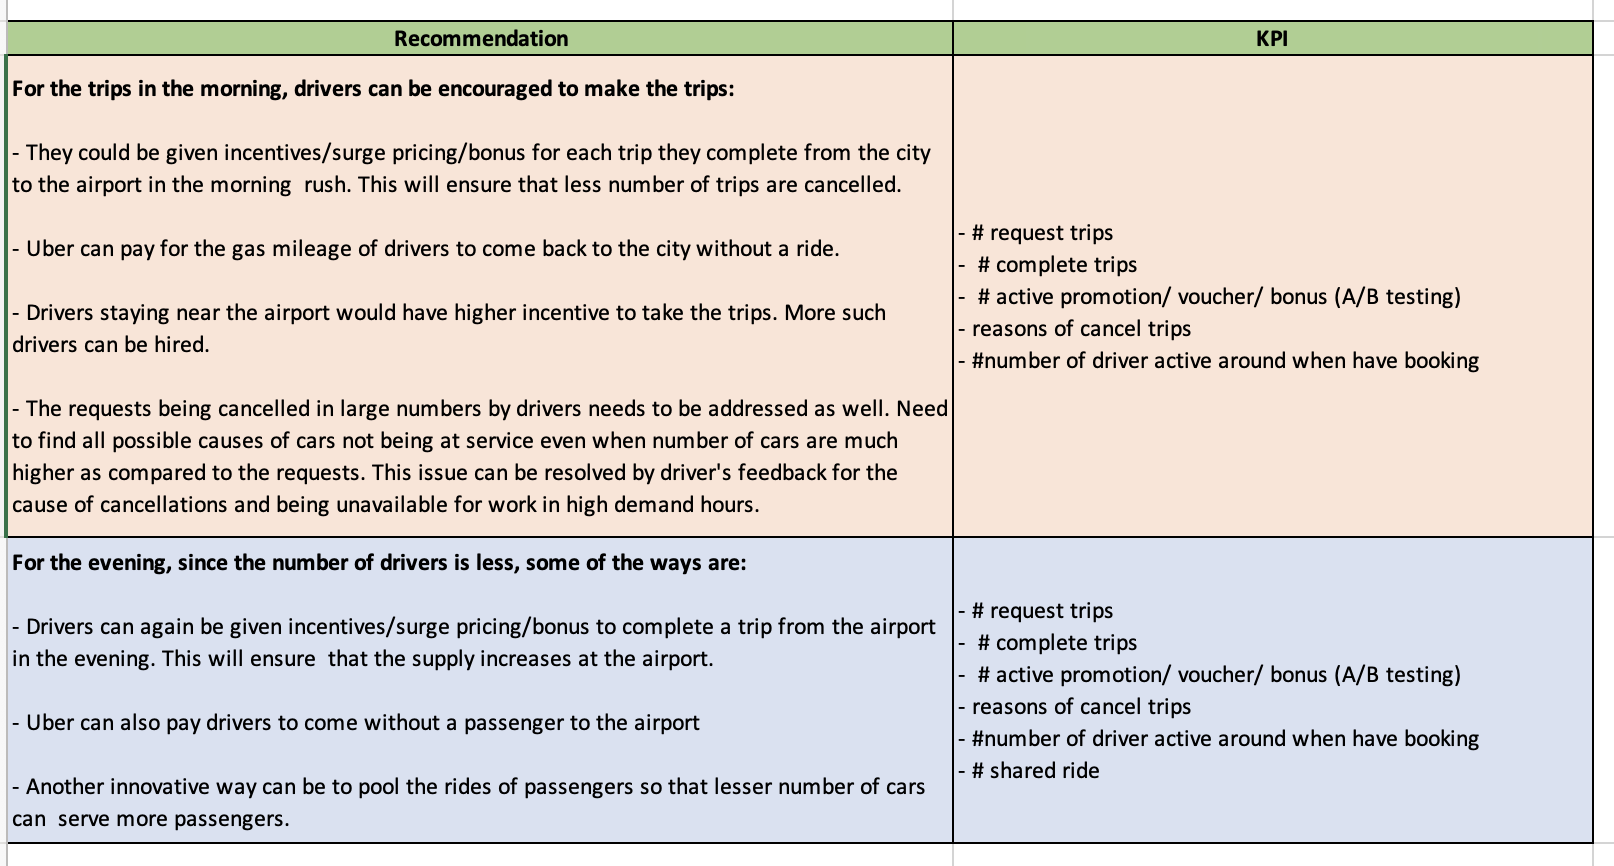